In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgbÇ
from xgboost import XGBClassifier as xgbc
import sklearn as slk
from sklearn.model_selection import cross_val_score as cv
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.model_selection import GridSearchCV as gs, RandomizedSearchCV as rs
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle

In [48]:
df = pd.read_csv("data/heart.csv")

In [5]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
df.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
le=LabelEncoder()

df['Sex']=le.fit_transform(df['Sex'])
df['RestingECG']=le.fit_transform(df['RestingECG'])
df['ChestPainType']=le.fit_transform(df['ChestPainType'])
df['ExerciseAngina']=le.fit_transform(df['ExerciseAngina'])
df['ST_Slope']=le.fit_transform(df['ST_Slope'])

In [8]:
df.shape

(918, 12)

In [49]:
dummified = pd.get_dummies(df, drop_first=True)

In [50]:
dummified.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


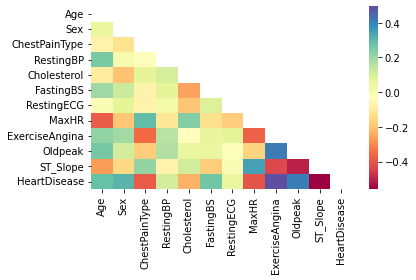

In [11]:
heatmap = sns.heatmap(dummified.corr(),mask= np.triu(np.ones_like(dummified.corr())), cmap="Spectral")
fig = heatmap.get_figure()
plt.tight_layout()
fig.savefig('img/CorrHeatmap.jpg')


In [12]:
df.groupby(['Sex','Age']).count()

ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  MaxHR  \
Sex Age                                                                        
0   30               1          1            1          1           1      1   
    31               1          1            1          1           1      1   
    32               1          1            1          1           1      1   
    33               1          1            1          1           1      1   
    34               2          2            2          2           2      2   
...                ...        ...          ...        ...         ...    ...   
1   72               4          4            4          4           4      4   
    74               6          6            6          6           6      6   
    75               3          3            3          3           3      3   
    76               1          1            1          1           1      1   
    77               2          2            2          2           2      2   

         ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
Sex Age                                                   
0   30                1        1         1             1  
    31                1        1         1             1  
    32                1        1         1             1  
    33                1        1         1             1  
    34                2        2         2             2  
...                 ...      ...       ...           ...  
1   72                4        4         4             4  
    74                6        6         6             6  
    75                3        3         3             3  
    76                1        1         1             1  
    77                2        2         2             2  

[91 rows x 10 columns]

In [13]:
sex_age=df[df['HeartDisease']==1].groupby(['Sex',pd.cut(df[df['HeartDisease']==1]["Age"], np.arange(28.0, 28.0+54.0, 5))]).count()

In [14]:
df[df.HeartDisease==1].Age.mean()

55.8996062992126

In [15]:
pd.crosstab(pd.cut(df["Age"], np.arange(28.0, 28.0+54.0, 5)), df.HeartDisease)

HeartDisease,0,1
Age,,
"(28.0, 33.0]",9,4
"(33.0, 38.0]",31,20
"(38.0, 43.0]",66,28
"(43.0, 48.0]",63,48
"(48.0, 53.0]",76,74
"(53.0, 58.0]",84,126
"(58.0, 63.0]",42,121
"(63.0, 68.0]",26,55
"(68.0, 73.0]",8,22


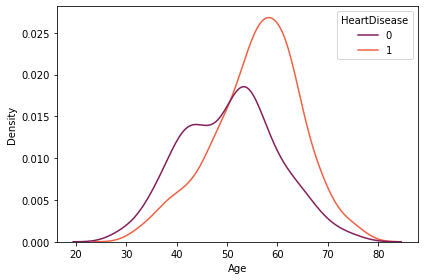

In [16]:
age = sns.kdeplot(data=df,x='Age',hue=df.HeartDisease, palette='rocket')
fig = age.get_figure()
plt.tight_layout()
fig.savefig('img/agekde.jpg')

<AxesSubplot:xlabel='Age', ylabel='Count'>

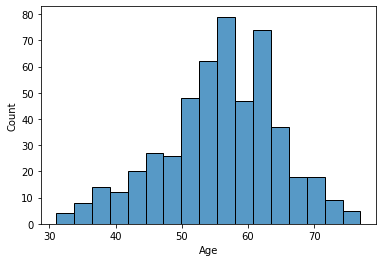

In [17]:
sns.histplot(data=df[df['HeartDisease']==1],x='Age')


<AxesSubplot:xlabel='Sex', ylabel='count'>

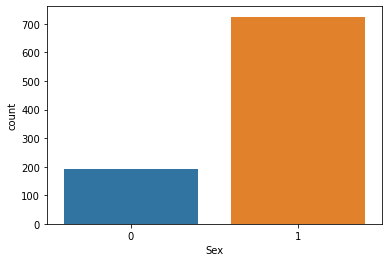

In [18]:
sns.countplot(data=df, x='Sex',  )

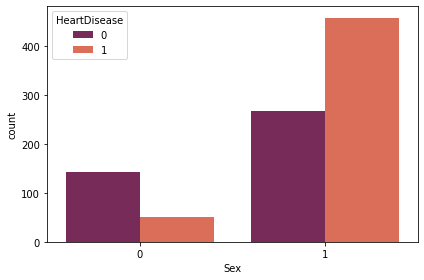

In [19]:
sex = sns.countplot(data=df, x='Sex', hue="HeartDisease", palette='rocket' )
fig = sex.get_figure()
plt.tight_layout()
fig.savefig('img/sexheartdisease.jpg')

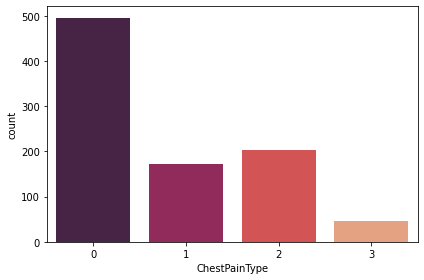

In [20]:
pain = sns.countplot(x = df['ChestPainType'], data = df[df['HeartDisease']==1], palette='rocket')
fig = pain.get_figure()
plt.tight_layout()
fig.savefig('img/paintype.jpg')

In [65]:
X_train, X_test, y_train, y_test = tts(dummified.drop(columns='HeartDisease'),dummified['HeartDisease'], test_size= 0.2, random_state = 666)

In [66]:
X_train

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
484,65,134,0,0,112,1.1,1,0,0,0,1,0,1,1,0
749,54,150,232,0,165,1.6,1,0,1,0,0,0,0,0,1
746,66,112,212,0,132,0.1,1,0,0,0,0,0,1,0,1
17,43,120,201,0,165,0.0,0,1,0,0,1,0,0,0,1
636,48,130,245,0,180,0.2,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,57,140,265,0,145,1.0,1,1,0,0,0,1,1,1,0
830,41,130,204,0,172,1.4,0,1,0,0,0,0,0,0,1
429,63,133,0,0,120,1.0,1,0,1,0,0,0,1,1,0
898,35,122,192,0,174,0.0,1,1,0,0,1,0,0,0,1


In [23]:
model = xgbc(eta=0.1,max_depth=8,use_label_encoder=False).fit((X_train), y_train)

[22:28:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
model2 = xgbc(learning_rate = 0.23959555026719673, max_depth = 6, n_estimators = 475, gamma = 0.42799057028468157,use_label_encoder=False).fit((X_train), y_train)

[22:39:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
pd.crosstab(model2.predict(X_test),y_test)

HeartDisease,0,1
row_0,,
0,59,10
1,17,98


In [55]:
dummified.shape

(918, 16)

In [27]:
model2.feature_importances_

array([0.02877211, 0.03367653, 0.11429007, 0.0278846 , 0.04423011,
       0.0520149 , 0.03581376, 0.03133741, 0.08747674, 0.04053108,
       0.5039727 ], dtype=float32)

In [56]:
dummified.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,1,0,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,1,0,0,0,1,0,0,1
3,48,138,214,0,108,1.5,1,0,0,0,0,1,0,1,1,0
4,54,150,195,0,122,0.0,0,1,0,1,0,1,0,0,0,1


In [29]:
model.predict_proba(X_test.sample())

array([[0.93063015, 0.06936987]], dtype=float32)

In [30]:
X_test.sample().columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [57]:
space={
    
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 25), # uniforme discreta de 10 a 1000 en saltos de 25
    
    'learning_rate': hp.uniform('learning_rate', 0.0001, 1.0), # uniforme continua entre 0.0001 y 1
    
    'max_depth': ho_scope.int(hp.quniform('my_param', 5, 10, q=1)),
    
    'gamma': hp.uniform('x_gamma', 0.1, 0.5)
}

In [58]:
def objetivo(space):
    
    modelo=xgbc(n_estimators=int(space['n_estimators']),
                            learning_rate=space['learning_rate'],
                            gamma=space['gamma'],
                            max_depth = space['max_depth'],
                            objective='reg:squarederror',
                            use_label_encoder=False
                           )
    
    eval_set=[(pf().fit_transform(X_train), y_train), (pf().fit_transform(X_test), y_test)]
    
    modelo.fit(pf().fit_transform(X_train), y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)
    
    y_pred=modelo.predict(pf().fit_transform(X_test))
    
    rmse=mse(y_test, y_pred)**0.5
    
    return {'loss': rmse, 'status': STATUS_OK}

In [59]:
mejor=fmin(fn=objetivo, space=space, algo=tpe.suggest, max_evals=20, trials=Trials())

mejor

100%|████████████████████████████████| 20/20 [00:26<00:00,  1.34s/trial, best loss: 0.3457820374040623]


{'learning_rate': 0.3427646258063571,
 'my_param': 5.0,
 'n_estimators': 175.0,
 'x_gamma': 0.12834493519350404}

In [34]:
cv(model2, X_train, y_train, scoring='accuracy', cv=5).mean()

[22:29:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:29:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

0.855595937004939

In [35]:
filename = 'finalized_model.sav'
pickle.dump(model2, open(filename, 'wb'))

In [72]:
a = X_test[X_test==X_test.loc[750]].dropna()

In [73]:
a

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
750,46.0,142.0,177.0,0.0,160.0,1.4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [75]:
y_test.loc[491]

1

In [ ]:
model2.predict_proba(a)

In [67]:
X_test

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
773,56,120,193,0,162,1.9,1,0,0,1,0,0,0,1,0
750,46,142,177,0,160,1.4,0,0,1,0,0,0,1,0,0
733,66,150,226,0,114,2.6,0,0,0,1,1,0,0,0,0
491,75,170,203,1,108,0.0,1,0,0,0,0,1,0,1,0
309,57,95,0,1,182,0.7,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,58,136,203,1,123,1.2,1,0,0,0,1,0,1,1,0
819,55,160,289,0,145,0.8,1,0,0,0,0,0,1,1,0
874,43,150,247,0,171,1.5,1,0,0,0,1,0,0,0,1
71,44,130,215,0,135,0.0,1,1,0,0,1,0,0,0,1


In [84]:
df[df==df.loc[750]].dropna()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
750,46.0,F,NAP,142.0,177.0,0.0,LVH,160.0,Y,1.4,Down,0.0


In [85]:
df[df==df.loc[491]].dropna()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
491,75.0,M,ASY,170.0,203.0,1.0,ST,108.0,N,0.0,Flat,1.0
